<a href="https://colab.research.google.com/github/Ganesh-Kdt/Assignment-2-NN/blob/neural_network_part2/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load the dataset through drive
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset.csv')
df.head()
print(df.shape)

Mounted at /content/drive
(766, 8)


In [2]:
#main statistics related to our dataset
df.info()
df=df.apply(pd.to_numeric,errors='coerce')
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   f1      766 non-null    object
 1   f2      766 non-null    object
 2   f3      766 non-null    int64 
 3   f4      766 non-null    object
 4   f5      766 non-null    object
 5   f6      766 non-null    object
 6   f7      766 non-null    object
 7   target  766 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 48.0+ KB


,f1,f2,f3,f4,f5,f6,f7,target
count,765.000000,765.000000,766.000000,765.000000,765.000000,765.000000,765.000000,766.000000
mean,3.849673,120.909804,69.118799,20.542484,80.091503,31.998170,0.472128,0.349869
std,3.373696,31.947945,19.376901,15.960515,115.374383,7.898275,0.331545,0.477240
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,0.000000
25%,1.000000,99.000000,62.500000,0.000000,0.000000,27.300000,0.244000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.374000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,128.000000,36.600000,0.626000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,1.000000


In [3]:
#converting NA values into median
for column in df.columns:
    unique_values = df[column].unique()
    for column_value in unique_values:
        if not isinstance(column_value, (int, float)):
            print(f"Invalid value '{column_value}' in column '{column}'")

for column in df.columns:
    if df[column].isna().any():
          df[column] = df[column].fillna(df[column].median())

Invalid value '72' in column 'f3'
Invalid value '66' in column 'f3'
Invalid value '64' in column 'f3'
Invalid value '40' in column 'f3'
Invalid value '74' in column 'f3'
Invalid value '50' in column 'f3'
Invalid value '0' in column 'f3'
Invalid value '70' in column 'f3'
Invalid value '96' in column 'f3'
Invalid value '92' in column 'f3'
Invalid value '80' in column 'f3'
Invalid value '60' in column 'f3'
Invalid value '84' in column 'f3'
Invalid value '30' in column 'f3'
Invalid value '88' in column 'f3'
Invalid value '90' in column 'f3'
Invalid value '94' in column 'f3'
Invalid value '76' in column 'f3'
Invalid value '82' in column 'f3'
Invalid value '75' in column 'f3'
Invalid value '58' in column 'f3'
Invalid value '78' in column 'f3'
Invalid value '68' in column 'f3'
Invalid value '110' in column 'f3'
Invalid value '56' in column 'f3'
Invalid value '62' in column 'f3'
Invalid value '85' in column 'f3'
Invalid value '86' in column 'f3'
Invalid value '48' in column 'f3'
Invalid value 

In [4]:
columns=['f1','f2','f3','f4','f5','f6','f7']
# def impute_outlier(df, column):
#     impute_column = df[column]
#     q1 = df[column].quantile(0.25)
#     q3 = df[column].quantile(0.75)
#     iqr = q3 - q1

#     lower_bound = q1 - 1.5 * iqr
#     upper_bound = q3 + 1.5 * iqr

#     non_outlier_median = impute_column[(df[column] >= lower_bound) & (df[column] <= upper_bound)].median()

#     def impute_value(value):
#         if value < lower_bound or value > upper_bound:
#             return non_outlier_median
#         else:
#             return value

#     df[column] = df[column].apply(impute_value)

# for column in columns:
#     impute_outlier(df, column)

# def normalize(df,column):
#     column_min = df[column].min()
#     column_max = df[column].max()
#     print("Minimum value for ",column," is: ",column_min)
#     print("Maximum value for ",column," is: ",column_max)
#     df[column] = (df[column] - column_min) / (column_max - column_min)

# for column in columns:
#     normalize(df,column)

# df.head(100)

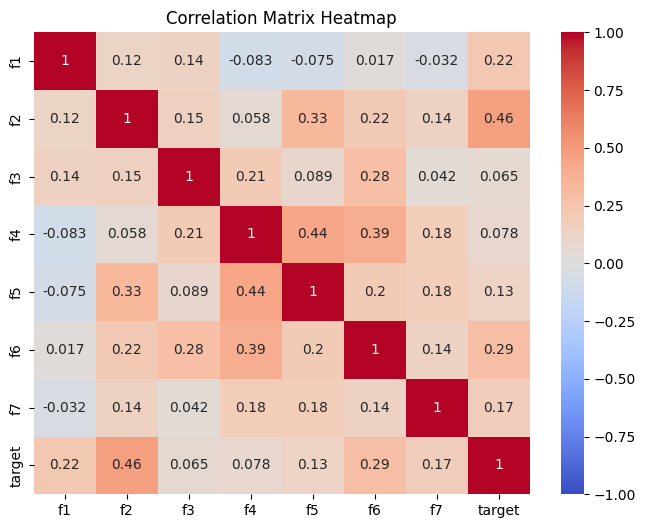

In [5]:
corr_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [6]:
pip install imbalanced-learn

In [7]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

#Scaling the dataset
X = df.drop(columns=['target','f3','f4','f5'])
y = df['target']
print(df['target'].value_counts())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Splitting the dataset into 70% training, 15% validation, 15% testing
X_temp, X_test, Y_temp, Y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.20, random_state=42, stratify=Y_temp)

smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_resampled.values, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32)

print("Training shape:", X_train_tensor.shape, Y_train_tensor.shape)
print("Validation shape:", X_val_tensor.shape, Y_val_tensor.shape)
print("Test shape:", X_test_tensor.shape, Y_test_tensor.shape)



target
0    498
1    268
Name: count, dtype: int64
Training shape: torch.Size([676, 4]) torch.Size([676])
Validation shape: torch.Size([131, 4]) torch.Size([131])
Test shape: torch.Size([115, 4]) torch.Size([115])


Validation loss improved from inf to 1.3033. Saving model...
Epoch [1/40], Training Loss: 0.6844, Validation Loss: 0.6517
Validation loss improved from 1.3033 to 1.2688. Saving model...
Epoch [2/40], Training Loss: 0.6526, Validation Loss: 0.6344
Validation loss improved from 1.2688 to 1.2403. Saving model...
Epoch [3/40], Training Loss: 0.6211, Validation Loss: 0.6202
Validation loss improved from 1.2403 to 1.2110. Saving model...
Epoch [4/40], Training Loss: 0.6034, Validation Loss: 0.6055
Validation loss improved from 1.2110 to 1.1852. Saving model...
Epoch [5/40], Training Loss: 0.5782, Validation Loss: 0.5926
Validation loss improved from 1.1852 to 1.1744. Saving model...
Epoch [6/40], Training Loss: 0.5665, Validation Loss: 0.5872
Validation loss improved from 1.1744 to 1.1663. Saving model...
Epoch [7/40], Training Loss: 0.5564, Validation Loss: 0.5832
Validation loss improved from 1.1663 to 1.1612. Saving model...
Epoch [8/40], Training Loss: 0.5545, Validation Loss: 0.5806
Val

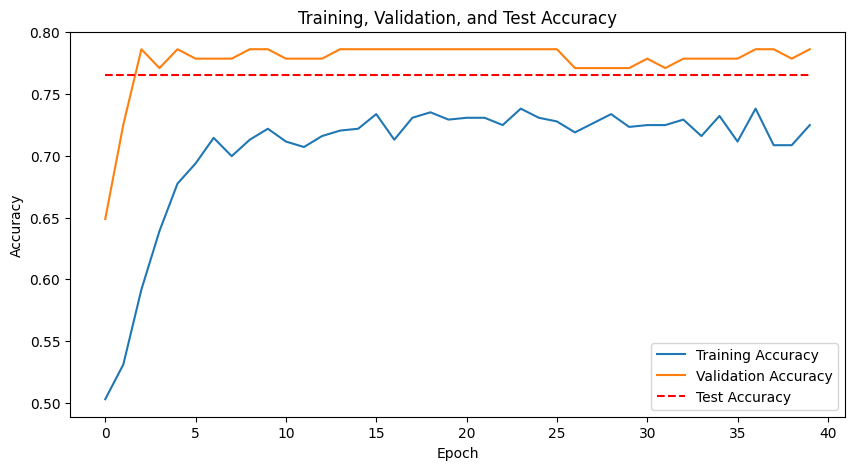

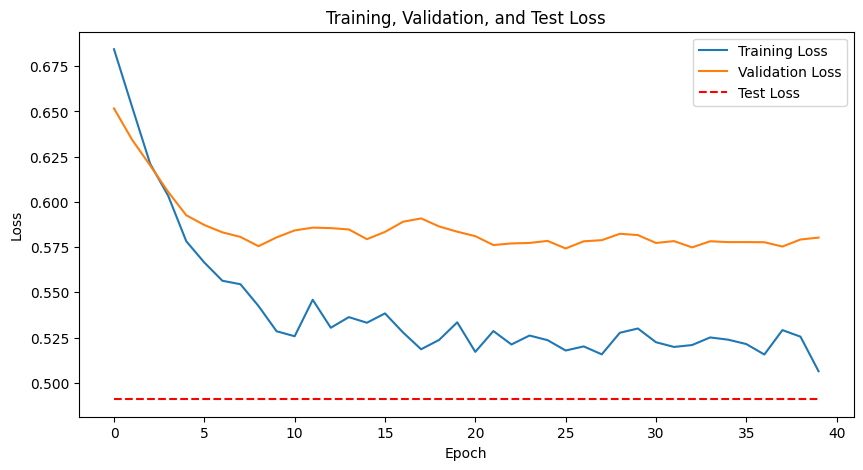

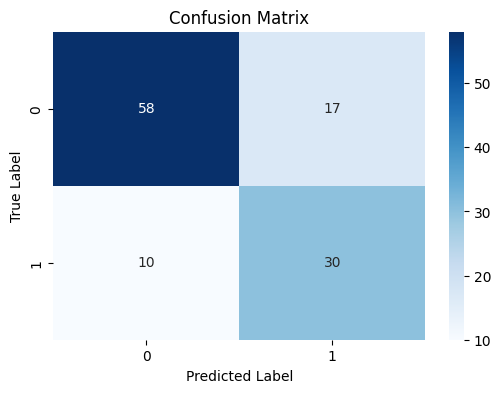

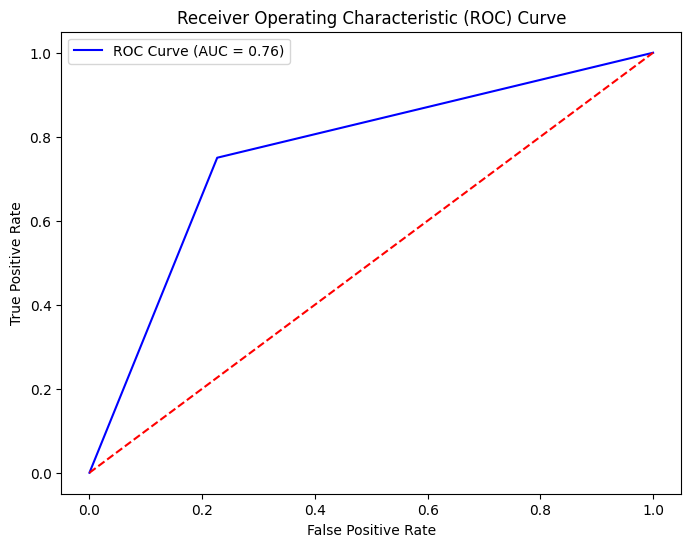

In [8]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc


# Step 1: Define the Neural Network architecture
class CustomNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size,dropout):
        super(CustomNeuralNetwork, self).__init__()
        # Input layer
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout)
        # Hidden layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size1)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout)
        # Output layer
        self.fc4 = nn.Linear(hidden_size1, output_size)
        self.sigmoid = nn.Sigmoid()  # Binary classification output

    def forward(self, x):
        output1 = self.fc1(x)
        output1 = self.relu1(output1)
        output1 = self.dropout(output1)
        output1 = self.fc2(output1)
        output2 = self.relu2(output1)
        output2 = self.dropout(output2)
        output3 = self.fc4(output2)
        output4 = self.sigmoid(output3)
        return output4

# Step 2: Initialize the model, loss function, and optimizer
input_size = 4  # Number of features
hidden_size1 = 64  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4

# model = CustomNeuralNetwork(input_size, hidden_size1, hidden_size2, output_size,dropout)
model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the model
epochs = 40  # Number of epochs
batch_size = 100  # Batch size

# DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, Y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_time = time.time()
# Save model weights
save_path = "best_weights.pth"
best_val_loss = float('inf')
best_epoch = 0
best_model_state_dict = None

for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), labels)  # Compute loss

        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        running_loss += loss.item()

        predicted_train = (outputs.squeeze() > 0.6).float()
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_labels).item()

            predicted_val = (val_outputs.squeeze() > 0.6).float()
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)

    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
        best_val_loss = val_loss
        best_epoch = epoch + 1
        best_model_state_dict = model.state_dict()

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

if best_model_state_dict is not None:
    torch.save(best_model_state_dict, save_path)
    print(f"Best model weights saved to {save_path} from epoch {best_epoch}")

end_time = time.time()  # Record the end time
training_time = end_time - start_time  # Calculate elapsed time
print(f"Total Training Time: {training_time:.2f} seconds")

# Step 4: Evaluate the model on the test set
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
correct = 0
total = 0
predicted_list = []
test_list = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()
        test_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")
test_loss = test_loss / len(test_loader)
print(f"Test Loss: {test_loss:.4f}")
precision, recall, f1, _ = precision_recall_fscore_support(test_list, predicted_list, average='binary')

# Print the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

test_accuracies = [accuracy / 100] * epochs
test_losses = [test_loss] * epochs

# Plot Training, Validation, and Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy', linestyle='--', color='red')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training, Validation, and Test Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--', color='red')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(test_list, predicted_list)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_list, predicted_list)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


Part II: Optimizing NN


Hyperparameter 1 change: Changing hidden size from 64 to 128

In [9]:
input_size = 4  # Number of features
hidden_size1 =128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the model
epochs = 40  # Number of epochs
batch_size = 100  # Batch size

start_time = time.time()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_time = time.time()

for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), labels)  # Compute loss

        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        running_loss += loss.item()

        predicted_train = (outputs.squeeze() > 0.6).float()
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_labels).item()

            predicted_val = (val_outputs.squeeze() > 0.6).float()
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)

    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
        best_val_loss = val_loss
        best_epoch = epoch + 1
        best_model_state_dict = model.state_dict()

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")


end_time = time.time()  # Record the end time
training_time_setup_1 = end_time - start_time  # Calculate elapsed time
print(f"Total Training Time Setup #1: {training_time_setup_1:.2f} seconds")

# Step 4: Evaluate the model on the test set
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
correct = 0
total = 0
predicted_list = []
test_list = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()
        test_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_1 = correct / total * 100
print(f"Test Accuracy Setup #1: {accuracy_setup_1:.2f}%")


Epoch [1/40], Training Loss: 0.6565, Validation Loss: 0.6555
Epoch [2/40], Training Loss: 0.6094, Validation Loss: 0.6276
Epoch [3/40], Training Loss: 0.5731, Validation Loss: 0.6026
Epoch [4/40], Training Loss: 0.5456, Validation Loss: 0.5897
Epoch [5/40], Training Loss: 0.5392, Validation Loss: 0.5881
Epoch [6/40], Training Loss: 0.5373, Validation Loss: 0.5823
Epoch [7/40], Training Loss: 0.5380, Validation Loss: 0.5850
Epoch [8/40], Training Loss: 0.5347, Validation Loss: 0.5963
Epoch [9/40], Training Loss: 0.5270, Validation Loss: 0.5953
Epoch [10/40], Training Loss: 0.5313, Validation Loss: 0.5834
Epoch [11/40], Training Loss: 0.5279, Validation Loss: 0.5815
Epoch [12/40], Training Loss: 0.5358, Validation Loss: 0.5820
Epoch [13/40], Training Loss: 0.5350, Validation Loss: 0.5787
Epoch [14/40], Training Loss: 0.5206, Validation Loss: 0.5828
Epoch [15/40], Training Loss: 0.5296, Validation Loss: 0.5760
Validation loss improved from 1.1485 to 1.1441. Saving model...
Epoch [16/40], 

Hyperparameter Setup #2: Using setup #1 as base model, increasing the batch size

In [10]:
input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the model
epochs = 40  # Number of epochs
batch_size = 1000  # Batch size

start_time = time.time()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_time = time.time()

for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), labels)  # Compute loss

        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        running_loss += loss.item()

        predicted_train = (outputs.squeeze() > 0.6).float()
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_labels).item()

            predicted_val = (val_outputs.squeeze() > 0.6).float()
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)

    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
        best_val_loss = val_loss
        best_epoch = epoch + 1
        best_model_state_dict = model.state_dict()

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")


end_time = time.time()  # Record the end time
training_time_setup_2 = end_time - start_time  # Calculate elapsed time
print(f"Total Training Time Setup #2: {training_time_setup_2:.2f} seconds")

# Step 4: Evaluate the model on the test set
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
correct = 0
total = 0
predicted_list = []
test_list = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()
        test_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_2 = correct / total * 100
print(f"Test Accuracy Setup #2: {accuracy_setup_2:.2f}%")


Epoch [1/40], Training Loss: 0.6600, Validation Loss: 0.6520
Epoch [2/40], Training Loss: 0.6004, Validation Loss: 0.6067
Epoch [3/40], Training Loss: 0.5650, Validation Loss: 0.5821
Epoch [4/40], Training Loss: 0.5478, Validation Loss: 0.5752
Epoch [5/40], Training Loss: 0.5471, Validation Loss: 0.5666
Validation loss improved from 1.1235 to 1.1153. Saving model...
Epoch [6/40], Training Loss: 0.5391, Validation Loss: 0.5577
Epoch [7/40], Training Loss: 0.5315, Validation Loss: 0.5641
Epoch [8/40], Training Loss: 0.5534, Validation Loss: 0.5646
Epoch [9/40], Training Loss: 0.5313, Validation Loss: 0.5593
Epoch [10/40], Training Loss: 0.5264, Validation Loss: 0.5626
Validation loss improved from 1.1153 to 1.1131. Saving model...
Epoch [11/40], Training Loss: 0.5292, Validation Loss: 0.5566
Validation loss improved from 1.1131 to 1.1115. Saving model...
Epoch [12/40], Training Loss: 0.5323, Validation Loss: 0.5558
Epoch [13/40], Training Loss: 0.5226, Validation Loss: 0.5571
Epoch [14/4

Hyperparameter Setup #3: Similarly using setup #2 as base and added two more hidden layers

In [11]:
class CustomNeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_size1, output_size,dropout):
    super(CustomNeuralNetwork, self).__init__()
    # Input layer
    self.fc1 = nn.Linear(input_size, hidden_size1)
    self.relu1 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout = nn.Dropout(dropout)

    # Hidden layer #1
    self.fc2 = nn.Linear(hidden_size1, hidden_size1)
    self.relu2 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout = nn.Dropout(dropout)

    # Hidden layer #2
    self.fc3 = nn.Linear(hidden_size1, hidden_size1)
    self.relu3 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout3 = nn.Dropout(dropout) # adding the dropout layer

    # Hidden layer #3
    self.fc4 = nn.Linear(hidden_size1, hidden_size1)
    self.relu4 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout4 = nn.Dropout(dropout) # adding the dropout layer

    # Output layer
    self.fc5 = nn.Linear(hidden_size1, output_size)
    self.sigmoid = nn.Sigmoid()  # Binary classification output

  def forward(self, x):
    output1 = self.fc1(x)
    output1 = self.relu1(output1)
    output1 = self.dropout(output1)

    output1 = self.fc2(output1)
    output2 = self.relu2(output1)
    output2 = self.dropout(output2)

    output2 = self.fc3(output2)
    output3 = self.relu3(output2)
    output3 = self.dropout3(output3)

    output3 = self.fc4(output3)
    output4 = self.relu4(output3)
    output4 = self.dropout4(output4)

    output4 = self.fc5(output4)
    output5 = self.sigmoid(output4)

    return output5

input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the model
epochs = 40  # Number of epochs
batch_size = 1000  # Batch size

start_time = time.time()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_time = time.time()

for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), labels)  # Compute loss

        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        running_loss += loss.item()

        predicted_train = (outputs.squeeze() > 0.6).float()
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_labels).item()

            predicted_val = (val_outputs.squeeze() > 0.6).float()
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)

    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
        best_val_loss = val_loss
        best_epoch = epoch + 1
        best_model_state_dict = model.state_dict()

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")


end_time = time.time()  # Record the end time
training_time_setup_3 = end_time - start_time  # Calculate elapsed time
print(f"Total Training Time Setup #3: {training_time_setup_3:.2f} seconds")

# Step 4: Evaluate the model on the test set
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
correct = 0
total = 0
predicted_list = []
test_list = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()
        test_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_3 = correct / total * 100
print(f"Test Accuracy Setup #3: {accuracy_setup_3:.2f}%")


Epoch [1/40], Training Loss: 0.6858, Validation Loss: 0.6871
Epoch [2/40], Training Loss: 0.6632, Validation Loss: 0.6630
Epoch [3/40], Training Loss: 0.6148, Validation Loss: 0.6143
Epoch [4/40], Training Loss: 0.5683, Validation Loss: 0.5968
Epoch [5/40], Training Loss: 0.5471, Validation Loss: 0.5798
Epoch [6/40], Training Loss: 0.5480, Validation Loss: 0.5871
Epoch [7/40], Training Loss: 0.5484, Validation Loss: 0.5545
Epoch [8/40], Training Loss: 0.5476, Validation Loss: 0.5753
Epoch [9/40], Training Loss: 0.5341, Validation Loss: 0.5743
Epoch [10/40], Training Loss: 0.5405, Validation Loss: 0.5624
Epoch [11/40], Training Loss: 0.5271, Validation Loss: 0.5709
Epoch [12/40], Training Loss: 0.5250, Validation Loss: 0.5788
Epoch [13/40], Training Loss: 0.5372, Validation Loss: 0.5927
Epoch [14/40], Training Loss: 0.5297, Validation Loss: 0.5602
Epoch [15/40], Training Loss: 0.5339, Validation Loss: 0.5650
Epoch [16/40], Training Loss: 0.5164, Validation Loss: 0.5813
Epoch [17/40], Tr

### The best out of the three setups was Setup #2 changing the batch size.

Improve the model : Methods to increase training speed, accuracy, etc.

In [12]:
#choose the best accuracy model
base_model_accuracy = max(accuracy_setup_1, accuracy_setup_2, accuracy_setup_3)
print(f'Base Model accuracy is: {base_model_accuracy}')

base_model_time = max(training_time_setup_1, training_time_setup_2, training_time_setup_3)
print(f'Base Model time is: {base_model_time}')

Base Model accuracy is: 76.52173913043478
Base Model time is: 4.335838556289673


Improved Model Method #1: Early Stopping, using the Setup #2 as base model.

In [13]:
import copy

input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the model
epochs = 40  # Number of epochs
batch_size = 1000  # Batch size

start_time = time.time()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_time = time.time()

# Variables used for Early Stopping
best_loss = float('inf')
counter = 0

for epoch in range(epochs):
  model.train()  # Set model to training mode
  running_loss = 0.0
  correct_train = 0
  total_train = 0
  for inputs, labels in train_loader:
    outputs = model(inputs)  # Forward pass
    loss = criterion(outputs.squeeze(), labels)  # Compute loss

    optimizer.zero_grad()  # Clear gradients
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    running_loss += loss.item()

    predicted_train = (outputs.squeeze() > 0.6).float()
    total_train += labels.size(0)
    correct_train += (predicted_train == labels).sum().item()

  train_losses.append(running_loss / len(train_loader))
  train_accuracies.append(correct_train / total_train)
  # Validation phase
  model.eval()  # Set model to evaluation mode
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for val_inputs, val_labels in val_loader:
      val_outputs = model(val_inputs)
      val_loss += criterion(val_outputs.squeeze(), val_labels).item()

      predicted_val = (val_outputs.squeeze() > 0.6).float()
      total_val += val_labels.size(0)
      correct_val += (predicted_val == val_labels).sum().item()
  val_losses.append(val_loss / len(val_loader))
  val_accuracies.append(correct_val / total_val)

  if val_loss < best_val_loss:
    print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
    best_val_loss = val_loss
    best_epoch = epoch + 1
    best_model_state_dict = model.state_dict()

  print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

  # Early stopping method
  if val_loss < best_loss:
    best_loss = val_loss
    best_model_weights = copy.deepcopy(model.state_dict())
    counter = 10  # Reset patience counter
  else:
    counter -= 1
    if counter == 0:
        break

end_time = time.time()  # Record the end time
training_time_early_stopping = end_time - start_time  # Calculate elapsed time
print(f"Total Training Time Early Stopping: {training_time_early_stopping:.2f} seconds")

# Step 4: Evaluate the model on the test set
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
correct = 0
total = 0
predicted_list = []
test_list = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()
        test_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_early_stopping = correct / total * 100
print(f"Test Accuracy Early Stopping: {accuracy_early_stopping:.2f}%")


Epoch [1/40], Training Loss: 0.6861, Validation Loss: 0.6736
Epoch [2/40], Training Loss: 0.6624, Validation Loss: 0.6537
Epoch [3/40], Training Loss: 0.6262, Validation Loss: 0.6257
Epoch [4/40], Training Loss: 0.5653, Validation Loss: 0.5743
Epoch [5/40], Training Loss: 0.5615, Validation Loss: 0.5673
Epoch [6/40], Training Loss: 0.5656, Validation Loss: 0.5589
Epoch [7/40], Training Loss: 0.5420, Validation Loss: 0.5622
Epoch [8/40], Training Loss: 0.5432, Validation Loss: 0.5575
Epoch [9/40], Training Loss: 0.5353, Validation Loss: 0.5535
Epoch [10/40], Training Loss: 0.5306, Validation Loss: 0.5734
Epoch [11/40], Training Loss: 0.5320, Validation Loss: 0.5619
Validation loss improved from 1.0844 to 1.0812. Saving model...
Epoch [12/40], Training Loss: 0.5277, Validation Loss: 0.5406
Epoch [13/40], Training Loss: 0.5298, Validation Loss: 0.5633
Epoch [14/40], Training Loss: 0.5380, Validation Loss: 0.5676
Epoch [15/40], Training Loss: 0.5427, Validation Loss: 0.5556
Epoch [16/40], 

In [14]:
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(base_model_accuracy, label='Base Model', color='blue')
# plt.plot(accuracy_early_stopping, label='Early Stopping Model', color='orange')
# plt.title('Model Accuracy Comparison')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid()

# # Training time comparison
# plt.subplot(1, 2, 2)
# plt.bar(['Base Model', 'Early Stopping Model'], [base_model_time, training_time_early_stopping], color=['blue', 'orange'])
# plt.title('Training Time Comparison')
# plt.ylabel('Time (seconds)')

# plt.tight_layout()
# plt.show()

Method #2 k-fold

In [21]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset

input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the model
epochs = 40  # Number of epochs
batch_size = 1000  # Batch size

#using the dataloader for kfold
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

#k-fold value
kf = KFold(n_splits=15, shuffle=True)

start_time = time.time()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_time = time.time()

for train_index, val_index in kf.split(train_dataset):

  train_subset = Subset(train_dataset, train_index)
  val_subset = Subset(train_dataset, val_index)

  # train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
  train_loader = torch.utils.data.DataLoader(dataset=train_subset,batch_size=batch_size, shuffle=True)

  # val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
  val_loader = torch.utils.data.DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

  for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
      outputs = model(inputs)  # Forward pass
      loss = criterion(outputs.squeeze(), labels)  # Compute loss

      optimizer.zero_grad()  # Clear gradients
      loss.backward()  # Backpropagation
      optimizer.step()  # Update weights
      running_loss += loss.item()

      predicted_train = (outputs.squeeze() > 0.6).float()
      total_train += labels.size(0)
      correct_train += (predicted_train == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
      for val_inputs, val_labels in val_loader:
        val_outputs = model(val_inputs)
        val_loss += criterion(val_outputs.squeeze(), val_labels).item()

        predicted_val = (val_outputs.squeeze() > 0.6).float()
        total_val += val_labels.size(0)
        correct_val += (predicted_val == val_labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)

    if val_loss < best_val_loss:
      print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
      best_val_loss = val_loss
      best_epoch = epoch + 1
      best_model_state_dict = model.state_dict()

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")


end_time = time.time()  # Record the end time
training_time_kfold = end_time - start_time  # Calculate elapsed time
print(f"Total Training Time K-Fold: {training_time_kfold:.2f} seconds")

# Step 4: Evaluate the model on the test set
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
correct = 0
total = 0
predicted_list = []
test_list = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()
        test_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_kfold = correct / total * 100
print(f"Test Accuracy K-Fold: {accuracy_kfold:.2f}%")


Epoch [1/40], Training Loss: 0.6943, Validation Loss: 0.6883
Epoch [2/40], Training Loss: 0.6919, Validation Loss: 0.6850
Epoch [3/40], Training Loss: 0.6872, Validation Loss: 0.6815
Epoch [4/40], Training Loss: 0.6825, Validation Loss: 0.6770
Epoch [5/40], Training Loss: 0.6789, Validation Loss: 0.6718
Epoch [6/40], Training Loss: 0.6735, Validation Loss: 0.6652
Epoch [7/40], Training Loss: 0.6674, Validation Loss: 0.6573
Epoch [8/40], Training Loss: 0.6597, Validation Loss: 0.6479
Epoch [9/40], Training Loss: 0.6527, Validation Loss: 0.6374
Epoch [10/40], Training Loss: 0.6379, Validation Loss: 0.6260
Epoch [11/40], Training Loss: 0.6305, Validation Loss: 0.6135
Epoch [12/40], Training Loss: 0.6214, Validation Loss: 0.6006
Epoch [13/40], Training Loss: 0.6123, Validation Loss: 0.5874
Epoch [14/40], Training Loss: 0.5996, Validation Loss: 0.5742
Epoch [15/40], Training Loss: 0.5934, Validation Loss: 0.5610
Epoch [16/40], Training Loss: 0.5684, Validation Loss: 0.5477
Epoch [17/40], Tr

Method #3: Batch Normaization